# 1 概述

对斯坦福提供的含有50000条IMDB评论的数据集进行情感分类。
分别用词袋（bag of word）、TF-IDF、word2vec词向量进行文本或单词向量化；用经典机器学习算法 Naive Bayes 和 SVM 以及深度学习算法 LSTM 进行分类。
使用召回率、F1及ROC曲线等指标评价了不同算法的分类效果。

# 2 内容
2.1 导入必要的模块

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from gensim import models
import collections
import re
import string
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib # joblib是pickle的增强版本，对于存储NumPy数组更有效
from sklearn.metrics import roc_curve,f1_score,recall_score #ROC曲线
from sklearn.utils import shuffle

from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


In [3]:
cache_dir="/content/drive/My Drive/Colab Notebooks/cache/sentiment_analysis"
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists


# 数据收集
解压数据并将其读入内存

In [ ]:
!gunzip /content/drive/My\ Drive/aclImdb_v1.tar.gz
!tar -xvf /content/drive/My\ Drive/aclImdb_v1.tar  -C '/content/drive/My Drive/Colab Notebooks/data'

将数据读入内存，合并为一个训练集和一个测试集

In [ ]:
def read_data(base):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    for folder in ["train","test"]:
        for label in ["pos","neg"]:
            path = os.path.join(base,folder,label)
            for file_name in os.listdir(path):
                with open(os.path.join(path,file_name), encoding='UTF-8') as review:
                    if folder == "train":
                        X_train.append(review.read())
                        if label == "pos":
                            Y_train.append(1)
                        else:
                            Y_train.append(0)
                    elif folder == "test":
                        X_test.append(review.read())
                        if label == "pos":
                            Y_test.append(1)
                        else:
                            Y_test.append(0)
    print("X_train ,Y_train :",len(X_train),len(Y_train))
    print("X_test ,Y_test:",len(X_test),len(Y_test))
    assert (len(X_train) == len(Y_train)),"X_train and Y_train length is not equal"
    assert (len(X_test) == len(Y_test)),"X_test and Y_test length is not equal"
    X_train,Y_train = shuffle(X_train,Y_train)
    X_test,Y_test = shuffle(X_test,Y_test)
    return X_train,Y_train,X_test,Y_test

In [ ]:
# base = "/content/drive/My Drive/Colab Notebooks/data/aclImdb"
base = "D:\\SourceCode\\NLP\\dataset\\aclImdb"
X_train,Y_train,X_test,Y_test = read_data(base)

X_train ,Y_train : 25000 25000
X_test ,Y_test: 25000 25000


查看样本

In [ ]:
for i in range(10):
    print(X_train[i],Y_train[i],X_test[i],Y_test[i])

An excellent film with great performances from Zack & Lochley. Much to their displeasure (& mine) Garibaldi arrived on station. (All due respect to Jerry Doyle but in Seasons 4 & 5 I lost sympathy for the character.) It doesn't take him long to start criticizing Zack (who I love best of all on the show)and taking charge. I'm sure Zack could have coped. The Soulhunter plot is fascinating, especially if you believe in heaven as Zack does. The humour supplements it nicely. 10/10 1 Why did they have to waste money on this crap?!<br /><br />WARNING! CONTAINS SPOILERS!!!<br /><br />The plot: down-to-earth-good-kind-girl meets a rich-snob-ignorant guy. Her boyfriend gets jealous and with the guy, they burn down a resturant? (Over an UGLY girl?) Guy has to stay in town to build a new resturant, perfect for the love story to begin. But, hark!!! The girl is dying!!! Isn't that a surprise boys and girls? But she teaches him love life, and enjoy it. He's sad she is dying. She dies. He is sad. But 

# 数据预处理
## 数据清洗
1. 删除HTML标签：原始数据包含一些HTML标签，例如`<br />`，这些标签使用 BeautifulSoup 模块将其删除。
2. 删除标点符号和数字：使用 String 的 punctuation 模块删除标点符号
3. 分词：将句子划分为单词
4. 去停用词：使用 nltk 的 stopwords 词库删除停用词。


In [ ]:
from bs4 import BeautifulSoup
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
import re
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


False

In [ ]:
stemmer = PorterStemmer()
stopWords = set(stopwords.words('english'))

In [ ]:
def review_to_word(review):
    soup = BeautifulSoup(review, "html5lib")
    text = "".join([text for text in soup.stripped_strings])
    for char in punctuation + "1234567890":
        text = text.replace(char, " ")

    words = text.lower().split()

    filter_words = []
    for word in words:
        if word not in stopWords: #去停用词
            filter_words.append(word)
    words = []
    for word in filter_words:
        words.append(stemmer.stem(word))
    return words


    # return filter_words


In [ ]:
# 生成一个不用 Poter Stemmer 处理的文本，作为LSTM的输入
def review_to_word_no_stemmer(review):
    soup = BeautifulSoup(review, "html5lib")
    text = "".join([text for text in soup.stripped_strings])
    for char in punctuation + "1234567890":
        text = text.replace(char, " ")

    words = text.lower().split()

    filter_words = []
    for word in words:
        if word not in stopWords: #去停用词
            filter_words.append(word)
    words = []
    
    return filter_words

In [ ]:
def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay

    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_word, data_train))
        words_test = list(map(review_to_word, data_test))

        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                                                              cache_data['words_test'], cache_data['labels_train'],
                                                              cache_data['labels_test'])

    return words_train, words_test, labels_train, labels_test

In [ ]:
# 处理数据
words_train, words_test, labels_train, labels_test = preprocess_data(
    X_train, X_test, Y_train, Y_test,
    cache_dir="/content/drive/My Drive/Colab Notebooks/cache/sentiment_analysis",
    cache_file="preprocessed_data.pkl")

# 查看处理后的结果
print("\n原文")
print(X_train[1])
print("\n处理后的文档")
print(words_train[1])
print("\n标签")
print(labels_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

原文
This movie is Damian Szifrón's second immersion in movies after his excellent character study in "El Fondo del Mar". With "Tiempo De Valientes" he creates extremely well done characters, far away from prototypes and with an unprecedented chemistry between them. I've seen Szifron's talent to present every character in a lighthearted way but just enough to involve us emotionally with them. His control over them is magnificent, so he restores on the movie a great direction and an overall brilliantly polished script, the characters laugh and cry with real sentiment and invite the viewer to join them in their emotions and their evolution on screen.<br /><br />The Spanish takes over the English, the Buenos Aires urban landscape at night replaces Hollywood sets and the premise is just as interesting as any other, so we have a film daring to compete over Hollywood's Machinery.<br /><br />But I want you to see the movie mainly bec

# 文本向量化

文本向量化使用了四种方法，分别是词袋预处理技术（Bag of Word）、TF-IDF预处理技术、GloVe、word2vec词向量




## 词袋预处理技术（Bag of Word）

###### 原理

​		Bag of words将文本中的词语转换为词频矩阵。对于一个文本，Bag of words忽略其词序和语法、句法，仅仅将其看做是一些词汇的集合，而文本中的每个词汇都是独立的。

###### 实现

* ​使用 `sklearn.feature_extraction.text.CountVectorizer()` 函数实现Bag of Word。



*   仅使用训练集生成 Bag of Word 的词汇表，用于将训练数据和测试数据转换为向量表示。需要选择合适的词汇量（这里选择5000），过大会导致矩阵维度过高训练缓慢，过小会丢失文本的信息。


*   训练集中的单词集可能与测试集中的单词集不完全相同，如果在转换训练集时遇到了词汇表中没有的单词，则将其忽略。
每次生成Bag of Word特征向量文件就将其存储到文件，下次使用Bag of Word特征向量文件直接读取，避免每次都要训练和生成Bag of Word特征向量。

*   此外还需要将 Bag of Word特征向量规范化，因为`CountVectorizer()`只是对单词计数，数值可能会相差很大，会影响后续学习过程。使用`sklearn.preprocessing.pr.normalize()` 将数值规范化。
*   每次生成Bag of Word特征向量文件就将其存储到文件，下次使用Bag of Word特征向量文件直接读取，避免每次都要训练和生成Bag of Word特征向量。
*   此外还需要将 Bag of Word特征向量规范化，因为`CountVectorizer()`只是对单词计数，数值可能会相差很大，会影响后续学习过程。使用`sklearn.preprocessing.pr.normalize()` 将数值规范化。


In [ ]:
def extract_BoW_features(words_train, words_test, vocabulary_size=5000, #词汇量
             cache_dir=cache_dir, cache_file="bow_features.pkl"):

    # 尝试读取已经生成的Bag of Word特征向量文件，避免每次运行这块时都重新处理数据生成BoW矩阵
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # 文件不存在，需要处理数据生成BoW矩阵

    
    if cache_data is None: # 处理数据生成BoW矩阵
        vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()  #训练并转换训练集
        features_test = vectorizer.transform(words_test).toarray()  # 转换测试集，不能用fit_transform

        if cache_file is not None: # 训练好的Bag of Word特征向量存文件，下次使用直接读取
            vocabulary = vectorizer.vocabulary_ #获取词汇表
            cache_data = dict(features_train=features_train, features_test=features_test,
                              vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)

    else: # 读取到了Bag of Word特征向量文件，将读取到的文件存档拆分并放到变量里
        features_train, features_test, vocabulary = (cache_data['features_train'],
                                cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_test, vocabulary


In [ ]:
# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)


Wrote features to cache file: bow_features.pkl


In [ ]:
print("Vocabulary: {} words".format(len(vocabulary)))

Vocabulary: 5000 words


In [ ]:
print("\n预处理后的样本")
print(words_train[0])
print("\n对应的 Bag of Word 特征向量")
print(features_train[0])
print("\nLabel")
print(labels_train[0])


预处理后的样本
['favorit', 'imperi', 'movi', 'one', 'best', 'action', 'adventur', 'flick', 'time', 'grant', 'mclaglen', 'fairbank', 'domin', 'screen', 'dare', 'wise', 'crack', 'pleas', 'pc', 'film', 'goer', 'memor', 'scene', 'abound', 'sergeant', 'sepoy', 'fight', 'hundr', 'thug', 'macchesney', 'cutter', 'give', 'bobbi', 'coot', 'spike', 'punch', 'save', 'eleph', 'cutter', 'macchesney', 'expedit', 'din', 'break', 'cutter', 'jail', 'fork', 'think', 'tri', 'break', 'bleedin', 'pud', 'incred', 'templ', 'scene', 'cutter', 'sing', 'annouc', 'bold', 'brass', 'right', 'arrest', 'could', 'go', 'suffic', 'say', 'tri', 'catch', 'film', 'whenev', 'armchair', 'adventur', 'gener', 'hard', 'imagin', 'better', 'hour']

对应的 Bag of Word 特征向量
[0 0 0 ... 0 0 0]

Label
1


In [ ]:
# 特征值规范化
from sklearn.preprocessing import normalize
features_train = normalize(features_train)
features_test = normalize(features_test)

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def extract_TFIDF_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="tfidf_features.pkl"):

    # 尝试读取已经生成的TFIDF特征向量文件，避免每次运行这块时都重新处理数据生成TFIDF矩阵
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass # 文件不存在，需要处理数据生成TFIDF矩阵

    # 处理数据生成TFIDF矩阵
    if cache_data is None:
        vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray() #训练并转换训练集

        features_test = vectorizer.transform(words_test).toarray()  # 转换测试集，不能用fit_transform

        if cache_file is not None:# 将训练好的特征向量存文件，下次使用直接读取
            vocabulary = vectorizer.vocabulary_ #获取词汇表
            cache_data = dict(features_train=features_train, features_test=features_test,
                              vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    
    else: # 已有TFIDF特征向量文件，将读取到的文件存档拆分并放到变量里
        features_train, features_test, vocabulary = (cache_data['features_train'],
                                cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_test, vocabulary


In [ ]:
# Extract Bag of Words features for both training and test datasets
tfidf_features_train, tfidf_features_test, tfidf_vocabulary = extract_TFIDF_features(words_train, words_test)


Wrote features to cache file: tfidf_features.pkl


In [ ]:
print("Vocabulary: {} words".format(len(tfidf_vocabulary)))

Vocabulary: 5000 words


In [ ]:
# 打印例子
print("\n预处理后的样本")
print(words_train[0])
print("\n对应的 TF-IDF 特征向量")
print(tfidf_features_train[0])
print("\nLabel")
print(labels_train[0])


预处理后的样本
['favorit', 'imperi', 'movi', 'one', 'best', 'action', 'adventur', 'flick', 'time', 'grant', 'mclaglen', 'fairbank', 'domin', 'screen', 'dare', 'wise', 'crack', 'pleas', 'pc', 'film', 'goer', 'memor', 'scene', 'abound', 'sergeant', 'sepoy', 'fight', 'hundr', 'thug', 'macchesney', 'cutter', 'give', 'bobbi', 'coot', 'spike', 'punch', 'save', 'eleph', 'cutter', 'macchesney', 'expedit', 'din', 'break', 'cutter', 'jail', 'fork', 'think', 'tri', 'break', 'bleedin', 'pud', 'incred', 'templ', 'scene', 'cutter', 'sing', 'annouc', 'bold', 'brass', 'right', 'arrest', 'could', 'go', 'suffic', 'say', 'tri', 'catch', 'film', 'whenev', 'armchair', 'adventur', 'gener', 'hard', 'imagin', 'better', 'hour']

对应的 TF-IDF 特征向量
[0. 0. 0. ... 0. 0. 0.]

Label
1


In [ ]:
# TFIDF  normalize
tfidf_features_train = normalize(tfidf_features_train)
tfidf_features_test = normalize(tfidf_features_test)

## Word2Vec

In [ ]:
# !gunzip '/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz'

In [6]:
# from gensim.models.keyedvectors import KeyedVectors
word2vec = models.KeyedVectors.load_word2vec_format(
    '/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [10]:
def extract_Word2vec_features(words_train, words_test,
              cache_dir=cache_dir, cache_file="word2vec_features.pkl"):

    # 尝试读取已经生成的TFIDF特征向量文件，避免每次运行这块时都重新处理数据生成TFIDF矩阵
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass # 文件不存在，需要处理数据生成TFIDF矩阵

    # 处理数据生成TFIDF矩阵
    if cache_data is None:
        features_train=[]
        for line in words_train:
            features_train.append(get_average_word2vec(line,word2vec)) 
        features_test=[]
        for line in words_test:
            features_test.append(get_average_word2vec(line,word2vec))

        if cache_file is not None:# 将训练好的特征向量存文件，下次使用直接读取
            cache_data = dict(features_train=features_train, features_test=features_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    
    else: # 已有TFIDF特征向量文件，将读取到的文件存档拆分并放到变量里
        features_train, features_test = (cache_data['features_train'],cache_data['features_test'])

    return features_train, features_test


In [11]:
Word2vec_features_train, Word2vec_features_test=extract_Word2vec_features(words_train, words_test)

Wrote features to cache file: word2vec_features.pkl


In [ ]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# 数据挖掘

# Naive Bayes
调用`sklearn.naive_bayes.GaussianNB`高斯朴素贝叶斯函数进行二分类，使用方法`fit()`训练集训练高斯朴素贝叶斯分类器，并使用`score()`在训练集和测试集上评估它的分类准确率。

In [15]:
from sklearn.naive_bayes import GaussianNB

Bag of Word + 朴素贝叶斯

In [ ]:
clf1 = GaussianNB()
clf1.fit(features_train,labels_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.81828, test = 0.72364


Recall:  0.61888
F1_score:  0.6913006568071132


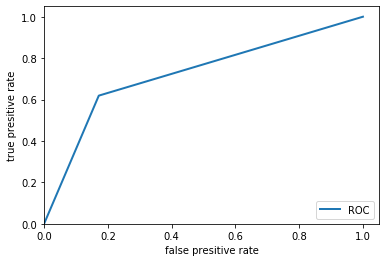

In [ ]:
y_pred1=clf1.predict(features_test)

# recall & F1
print( "Recall: ", recall_score(labels_test, y_pred1))
print( "F1_score: ", f1_score(labels_test, y_pred1))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(labels_test,y_pred1)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()

TF-IDF + 朴素贝叶斯

In [ ]:
# TF-IDF + 朴素贝叶斯
clf3 = GaussianNB()
clf3.fit(tfidf_features_train,labels_train)

# 计算训练集和测试集上的准确率
print("[{}] Accuracy: train = {}, test = {}".format(
        clf3.__class__.__name__,
        clf3.score(tfidf_features_train, labels_train),
        clf3.score(tfidf_features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.82752, test = 0.73092


Recall:  0.5788
F1_score:  0.6860421012706239


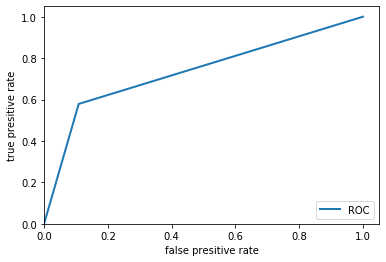

In [ ]:
y_pred3=clf3.predict(features_test)

# recall & F1
print( "Recall: ", recall_score(labels_test, y_pred3))
print( "F1_score: ", f1_score(labels_test, y_pred3))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(labels_test,y_pred3)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()



Word2Vec + Naive Bayes

In [16]:
clf5 = GaussianNB()
clf5.fit(np.array(Word2vec_features_train),np.array(labels_train))

print("[{}] Accuracy: train = {}, test = {}".format(
        clf5.__class__.__name__,
        clf5.score(Word2vec_features_train, labels_train),
        clf5.score(Word2vec_features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.7776, test = 0.77404


Recall:  0.75256
F1_score:  0.7690798348526345


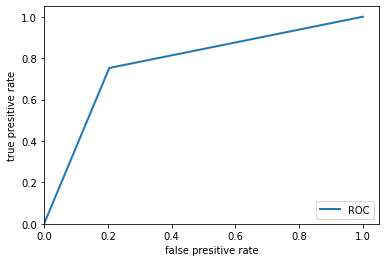

In [17]:
y_pred5=clf5.predict(Word2vec_features_test)

# recall & F1
print( "Recall: ", recall_score(labels_test, y_pred5))
print( "F1_score: ", f1_score(labels_test, y_pred5))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(labels_test,y_pred5)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()

# SVM
调用`sklearn.naive_bayes.GaussianNB`高斯朴素贝叶斯函数进行二分类，使用方法`fit()`训练集训练高斯朴素贝叶斯分类器，并使用`score()`在训练集和测试集上评估它的分类准确率。

Bag of Word + SVM

In [13]:
from sklearn import svm

In [ ]:
# TODO: Train a SVM classifier
clf2 = svm.SVC(kernel='linear',verbose=True)
clf2.fit(features_train,labels_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=True)

In [ ]:
# 计算分类准确率
print("[{}] Accuracy: train = {}, test = {}".format(
        clf2.__class__.__name__,
        clf2.score(features_train, labels_train),
        clf2.score(features_test, labels_test)))

[SVC] Accuracy: train = 0.9136, test = 0.87612


Recall:  0.8776
F1_score:  0.8763030714542478


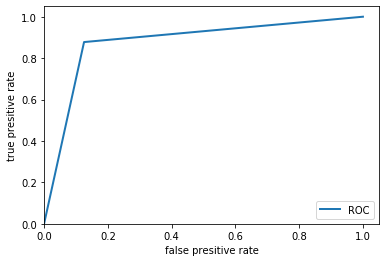

In [ ]:
y_pred2=clf2.predict(features_test)

# recall & F1
print( "Recall: ", recall_score(labels_test, y_pred2))
print( "F1_score: ", f1_score(labels_test, y_pred2))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(labels_test,y_pred2)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()

TF-IDF + SVM

In [ ]:
clf4 = svm.SVC(kernel='linear',verbose=True)
clf4.fit(tfidf_features_train,labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf4.__class__.__name__,
        clf4.score(tfidf_features_train, labels_train),
        clf4.score(tfidf_features_test, labels_test)))

[LibSVM][SVC] Accuracy: train = 0.926, test = 0.87468


Recall:  0.89536
F1_score:  0.8741018431740081


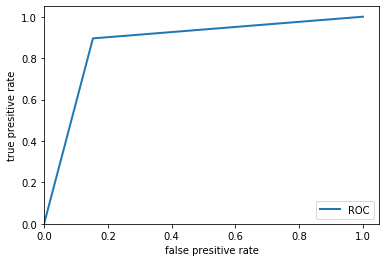

In [ ]:
y_pred4=clf4.predict(tfidf_features_test)

# recall & F1
print( "Recall: ", recall_score(labels_test, y_pred4))
print( "F1_score: ", f1_score(labels_test, y_pred4))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(labels_test,y_pred4)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()

Word2Vec + SVM

In [14]:
clf6 = svm.SVC(kernel='linear',verbose=True)
clf6.fit(np.array(Word2vec_features_train),np.array(labels_train))

print("[{}] Accuracy: train = {}, test = {}".format(
        clf6.__class__.__name__,
        clf6.score(Word2vec_features_train, labels_train),
        clf6.score(Word2vec_features_test, labels_test)))

[LibSVM][SVC] Accuracy: train = 0.85984, test = 0.85612


Recall:  0.85872
F1_score:  0.856493117893477


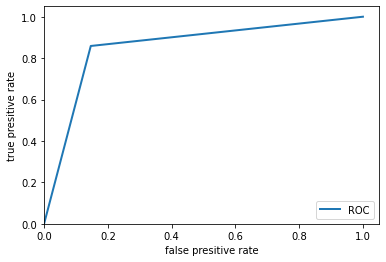

In [18]:
y_pred6=clf6.predict(Word2vec_features_test)

# recall & F1
print( "Recall: ", recall_score(labels_test, y_pred6))
print( "F1_score: ", f1_score(labels_test, y_pred6))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(labels_test,y_pred6)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()

# LSTM
## 处理数据


In [4]:
def load_preprocessed_data(cache_dir=cache_dir, cache_file="preprocessed_data_NoStemmer.pkl"):
  with open(os.path.join(cache_dir, cache_file), "rb") as f:
    cache_data = pickle.load(f)
  print("Read preprocessed data from cache file:", cache_file)
  words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
    cache_data['words_test'], cache_data['labels_train'],
    cache_data['labels_test'])

  return words_train, words_test, labels_train, labels_test

In [5]:
words_train, words_test, labels_train, labels_test=load_preprocessed_data(
    cache_dir='/content/drive/My Drive/Colab Notebooks/cache/sentiment_analysis')


Read preprocessed data from cache file: preprocessed_data_NoStemmer.pkl


In [ ]:
data_train_dict={
    'Text_Final':[' '.join(words for words in row) for row in words_train],
    'tokens':words_train,
    "Label":labels_train,
    "Pos":labels_train,
    "Neg":[1-i for i in labels_train]
}
data_train=pd.DataFrame(data_train_dict)
data_train[:5]

,Text_Final,tokens,Label,Pos,Neg
0,one better kung fu movies quite flawless hoped...,"[one, better, kung, fu, movies, quite, flawles...",1,1,0
1,let go straight point movie would take desert ...,"[let, go, straight, point, movie, would, take,...",1,1,0
2,spoilers alerthomeward bound incredible journe...,"[spoilers, alerthomeward, bound, incredible, j...",1,1,0
3,gillian holroyd kim novak witch secretly attra...,"[gillian, holroyd, kim, novak, witch, secretly...",1,1,0
4,story show good really depressing hate depress...,"[story, show, good, really, depressing, hate, ...",0,0,1


In [ ]:
data_test_dict={
    'Text_Final':[' '.join(words for words in row) for row in words_test],
    'tokens':words_test,
    "Label":labels_test,
    "Pos":labels_test,
    "Neg":[1-i for i in labels_test]
}
data_test=pd.DataFrame(data_test_dict)
data_test[:5]

,Text_Final,tokens,Label,Pos,Neg
0,without doubt worst movie ever seen life nothi...,"[without, doubt, worst, movie, ever, seen, lif...",0,0,1
1,like used watch enjoy high budget hollywood fi...,"[like, used, watch, enjoy, high, budget, holly...",1,1,0
2,howler bad unintentionally funny tom conway po...,"[howler, bad, unintentionally, funny, tom, con...",0,0,1
3,flying war movie buff ranks bottom list histor...,"[flying, war, movie, buff, ranks, bottom, list...",0,0,1
4,minute pray second die clay mccord alex cord u...,"[minute, pray, second, die, clay, mccord, alex...",1,1,0


## 将文本序列化

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300

In [ ]:
# 获取所有词汇和词汇表，以及最长的文本单词数：
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

2989070 words total, with a vocabulary size of 75200
Max sentence length is 1416


In [ ]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

2919765 words total, with a vocabulary size of 74367
Max sentence length is 1154


In [ ]:
# 使用Keras的Tokenizer类将文本转换为序列
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 75200 unique tokens.


In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## 计算 Embedding Layer 参数矩阵

In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(75201, 300)


## 构建LSTM

In [ ]:
label_names = ['Pos', 'Neg']

In [ ]:
y_train = data_train[label_names].values

In [ ]:
x_train = train_cnn_data
y_tr = y_train

In [ ]:
def recurrent_nn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    
    embedding_layer = Embedding(num_words,
                  embedding_dim,
                  weights=[embeddings],
                  input_length=max_sequence_length,
                  trainable=False)
    embedded_sequences = embedding_layer(sequence_input)
    lstm = LSTM(256)(embedded_sequences)
    
    x = Dense(128, activation='relu')(lstm)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
model = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         22560300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 23,163,822
Trainable params: 603,522
Non-trainable params: 22,560,300
_________________________________________

## 训练 LSTM

In [ ]:
num_epochs = 5
batch_size = 32

In [ ]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 3025s 134ms/step - loss: 0.4576 - acc: 0.7935 - val_loss: 0.3605 - val_acc: 0.8436
Epoch 2/5
22500/22500 [==============================] - 3053s 136ms/step - loss: 0.3567 - acc: 0.8516 - val_loss: 0.3437 - val_acc: 0.8624
Epoch 3/5
22500/22500 [==============================] - 3071s 137ms/step - loss: 0.3057 - acc: 0.8766 - val_loss: 0.3070 - val_acc: 0.8752
Epoch 4/5
22500/22500 [==============================] - 3064s 136ms/step - loss: 0.2742 - acc: 0.8913 - val_loss: 0.3015 - val_acc: 0.8790
Epoch 5/5
22500/22500 [==============================] - 3099s 138ms/step - loss: 0.2463 - acc: 0.9023 - val_loss: 0.2974 - val_acc: 0.8864


## 测试 LSTM

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

25000/25000 [==============================] - 784s 31ms/step


In [ ]:
labels = [1, 0]
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.88612

Recall:  0.89744
F1_score:  0.8873946920855912


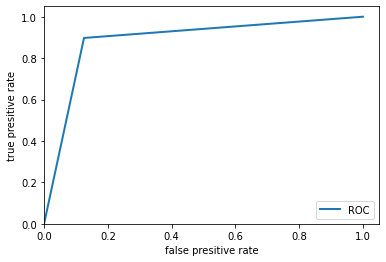

In [ ]:
# recall & F1
print( "Recall: ", recall_score(data_test.Label,prediction_labels))
print( "F1_score: ", f1_score(data_test.Label,prediction_labels))

# 画ROC曲线
fpr, tpr, thresholds=roc_curve(data_test.Label,prediction_labels)
plt.plot(fpr,tpr,linewidth=2,label="ROC")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(0,1.05)
plt.legend(loc=4)#图例的位置
plt.show()

# 总结



| 分类算法\文本预处理算法 | Bag of Word                     | TF-IDF                          | Word2Vec                        |
| ----------------------- | ------------------------------- | ------------------------------- | ------------------------------- |
| Naive Bayes             | train = 0.81828, test = 0.72364 | train = 0.82752, test = 0.73092 | train = 0.7776, test = 0.77404  |
| SVM                     | train = 0.91364, test = 0.87624 | train = 0.92604, test = 0.87472 | train = 0.85984, test = 0.85612 |
| LSTM                    |                                 |                                 | train = 0.9023，test = 0.88612  |

- 不同预处理方法对分类模型效果影响

  ​		对于 Bag of Word 、TF-IDF、Word2Vec 这三种文本处理方法，Word2Vec 是最好的，TF-IDF 次之，Bag of Word 最差。Word2Vec 将单词映射到低维稠密的向量，具有良好的语义特性，每一维表示词语的一个潜在特征，该特征捕获了有用的句法和语义特性；TF-IDF、Word2Vec都将单词映射到高维稀疏向量，并且不具有语义， Bag of Word 只计词频，不计单词在语料库中出现的频率，会赋予常用的不重要的词汇高权重；TF-IDF 是Bag of Word的优化，考虑了词频和逆文档频率，能够过滤掉常见的词语，保留重要的词语。

  

- 比较不同模型分类效果

  分类准确率：LSTM > SVM > Naive Bayes

  ​		LSTM 适合处理序列变化的数据，对于文本类型的数据，可以将文本切分为单词，每个单词用向量表示，LSTM输入词向量表示的文本序列，能够发掘序列中数据的依赖关系。

  ​		对于SVM 和 Naive Bayes，只能将文本转化为一个向量表示，不能捕捉到序列的变化过程，不适用于处理序列的输入。
  
  

​        使用Word2Vec + LSTM的结果是最好的，Word2Vec 能够表示词的语义，LSTM较为适合处理序列变化的数据，能够发掘序列中数据的依赖关系，二者结合能够较好地分析文本序列。
